In [1]:
# the default additions to my notebook
import numpy as np
import pandas as pd

# matplotlib, seaborn, plotly are added for visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# stats is added for any computational work that needs to be done
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

# utilized for creating models 
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

# custom files used to import functions created by me and tailored for the zillow dataset
import wrangle
import evaluate
import env

import warnings
warnings.filterwarnings('ignore')

# Regression Project: Estimating Home Value

## By Larry Holmes

## Project Goals

> - Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways.
> - Create modules (acquire.py, prepare.py) that make my process repeateable and my report (notebook) easier to read and follow.
> - Ask exploratory questions of my data that will help me understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.
> - Construct a model to predict assessed home value for single family properties using regression techniques.
> - Make recommendations to a data science team about how to improve predictions.
> - Refine my work into a report, in the form of a jupyter notebook, that I will walk through in a 5 minute presentation to a group of collegues and managers about my goals, the work I did, why, what I found, my methodologies, and my conclusions.
> - Be prepared to answer panel questions about my code, process, findings and key takeaways, and model.

## Business Goals

> - Construct a ML Regression model that predicts property tax assessed values ('taxvaluedollarcnt') of **Single Family Properties** using attributes of the properties.
> - Find the key drivers of property value for single family properties.
> - Deliver a report that you can read through and replicate, understand what steps were taken, why and what the outcome was.
> - Make recommendations on what works or doesn't work in predicting these homes values.

## Executive Summary - Key Findings and Recommendations
> 1. Utilizing the following features outlined in X_train, X_validate, and X_test I was able to narrow down my best model for predicting tax value of properties given using a 2nd degree Polynomial Regression model.

> 2. Many features help to predict tax value with the top features being area, fips, county, and zip which matched my original thoughts that location based features would be the strongest predictors within my model. 

> 3. My recommendations are that we find a better way of predicting tax value because although my best model outperforms baseline predictions, there is still a lot of room for error.  Maybe a different methodology can be used or a better sample of data can be captured since much of the given data had erroneous outliers or missing values.

# Acquire Phase

In [2]:
# Acquire zillow dataset from Codeup Database
df = wrangle.get_zillow_data()
df.head()

,bedrooms,bathrooms,garages,pools,area,lot_size,fips,county,city,zip,yearbuilt,tax_value
0,4.0,3.5,2.0,NaN,3100.0,4506.0,6059.0,1286.0,53571.0,96978.0,1998.0,1023282.0
1,2.0,1.0,1.0,NaN,1465.0,12647.0,6111.0,2061.0,13091.0,97099.0,1967.0,464000.0
2,3.0,2.0,2.0,1.0,1243.0,8432.0,6059.0,1286.0,21412.0,97078.0,1962.0,564778.0
3,4.0,3.0,NaN,1.0,2376.0,13038.0,6037.0,3101.0,396551.0,96330.0,1970.0,145143.0
4,4.0,3.0,NaN,1.0,2962.0,63000.0,6037.0,3101.0,47019.0,96293.0,1950.0,773303.0


# Prepare Phase

In [3]:
df['yearbuilt'] = df.yearbuilt.apply(wrangle.check_decade)
df = df.rename(columns={'yearbuilt':'decade'})

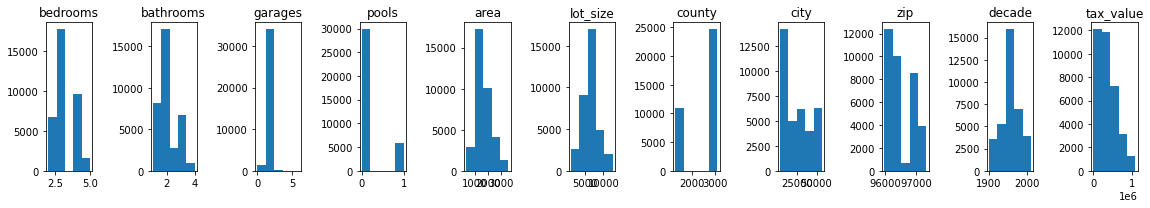

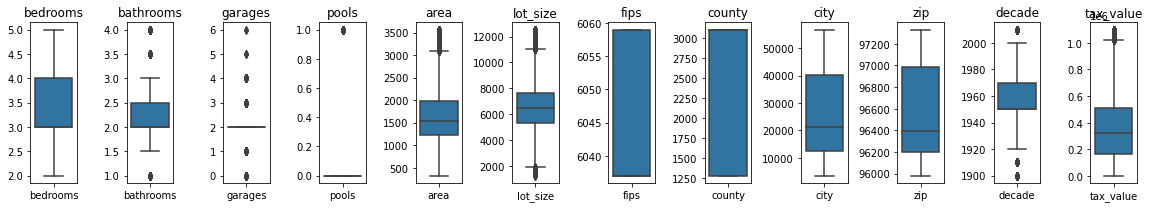

,bedrooms,bathrooms,garages,pools,area,lot_size,fips,county,city,zip,decade,tax_value
34441,4.0,2.0,2.0,0.0,1624.0,6269.0,6037.0,3101.0,5534.0,97318.0,1980,149204.0
43694,2.0,2.0,2.0,0.0,912.0,6931.0,6037.0,3101.0,54212.0,96510.0,1940,312261.0
50516,4.0,2.0,2.0,0.0,1446.0,9545.0,6059.0,1286.0,8384.0,97008.0,1960,66931.0
44791,3.0,3.5,2.0,0.0,3274.0,7073.0,6059.0,1286.0,24812.0,97041.0,2000,834699.0
31717,3.0,1.0,2.0,1.0,1210.0,5890.0,6037.0,3101.0,12292.0,96212.0,1950,332567.0


In [4]:
# Call prepare_zillow function to remove outliers, fill/remove nulls, give preliminary univariate visualizations, 
# split the data into train, validate, test datasets, seperate the target variable from independent variables,
# and create a copy of train, validate, and test datasets that are scaled.
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prepare_zillow(df, 'tax_value', ['bedrooms', 'bathrooms', 'area', 'lot_size', 'fips', 'county', 'city', 'zip', 'decade', 'tax_value'])
train.head()

## Prepare Takeaways

> - There were a lot of null variables and outliers, which once removed, took our dataset from 52,441 records to 34,961.
> - Initial review of individual variables shows a wide range of different value counts

# Explore Phase

## Initial Hypothesis
-  Area and rooms alone won't be the best predictor after constructing our MVP model using only those features.  With the inclusion of variables that help outline location based features of each house we will be able to better predict an accurate property tax assessed values of a single family home.

<function matplotlib.pyplot.show(close=None, block=None)>

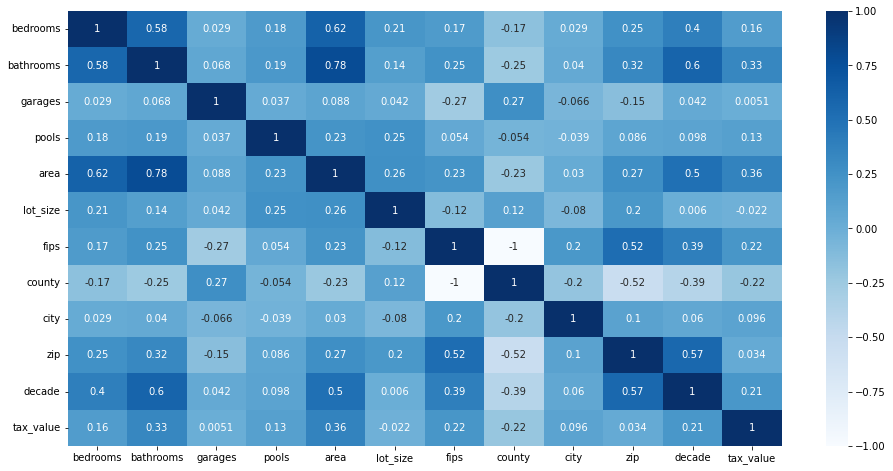

In [5]:
# Creating a heatmap to visualize the correlation between all variables
zillow_corr = train.corr(method='spearman')

plt.figure(figsize=(16, 8))
sns.heatmap(zillow_corr, cmap='Blues', annot=True)
plt.show

### Rooms (Bedrooms & Bathrooms) and Area are highly correlated with each other abd have the highest correlation with Tax_Value.  It seems that the location based features have a low correlation with tax_value and with each other.  Due to area and bathrooms/bedrooms having a high correlation with each other as independent variables, I may not want to use all three of them within a linear regression model hence why my MVP had a low increase in accuracy from the baseline.

In [6]:
# Using hypothesis testing (Spearman Test) to show correlation of each independent variable
# with the target varibale using a more scientific approach
for col in train:
    print(col)
    r, p_value = spearmanr(train[col], train.tax_value)

    print(f'Correlation Coefficient by Spearman Test: {r}\np-value: {p_value}')
    print()

    if p_value < 0.05:
        print('We can reject the null hypothesis')
        print()
    else:
        print('we cannot reject the null hypothesis')
        print()

bedrooms
Correlation Coefficient by Spearman Test: 0.16007283341631734
p-value: 1.8014658778036614e-114

We can reject the null hypothesis

bathrooms
Correlation Coefficient by Spearman Test: 0.3344053125399522
p-value: 0.0

We can reject the null hypothesis

garages
Correlation Coefficient by Spearman Test: 0.005148209733945725
p-value: 0.4674456710985847

we cannot reject the null hypothesis

pools
Correlation Coefficient by Spearman Test: 0.12865915601087605
p-value: 2.7106172073635398e-74

We can reject the null hypothesis

area
Correlation Coefficient by Spearman Test: 0.3649471079883518
p-value: 0.0

We can reject the null hypothesis

lot_size
Correlation Coefficient by Spearman Test: -0.022491599025408225
p-value: 0.001498646013298341

We can reject the null hypothesis

fips
Correlation Coefficient by Spearman Test: 0.218137267107924
p-value: 3.2084251916085445e-213

We can reject the null hypothesis

county
Correlation Coefficient by Spearman Test: -0.218137267107924
p-value: 3

### Upon utilizing the Spearman Test to check for correlation via hypothesis testing, I discovered that all features selected had some correlation to tax_value except for garages.  Garages will be removed from modeling once we get to that phase.

## Although my location based features have a very low correlation, I want to visualize their relationship to tax value to see if there is any pattern in terms of groupings.  Are there locations that have higher tax values than other locations?

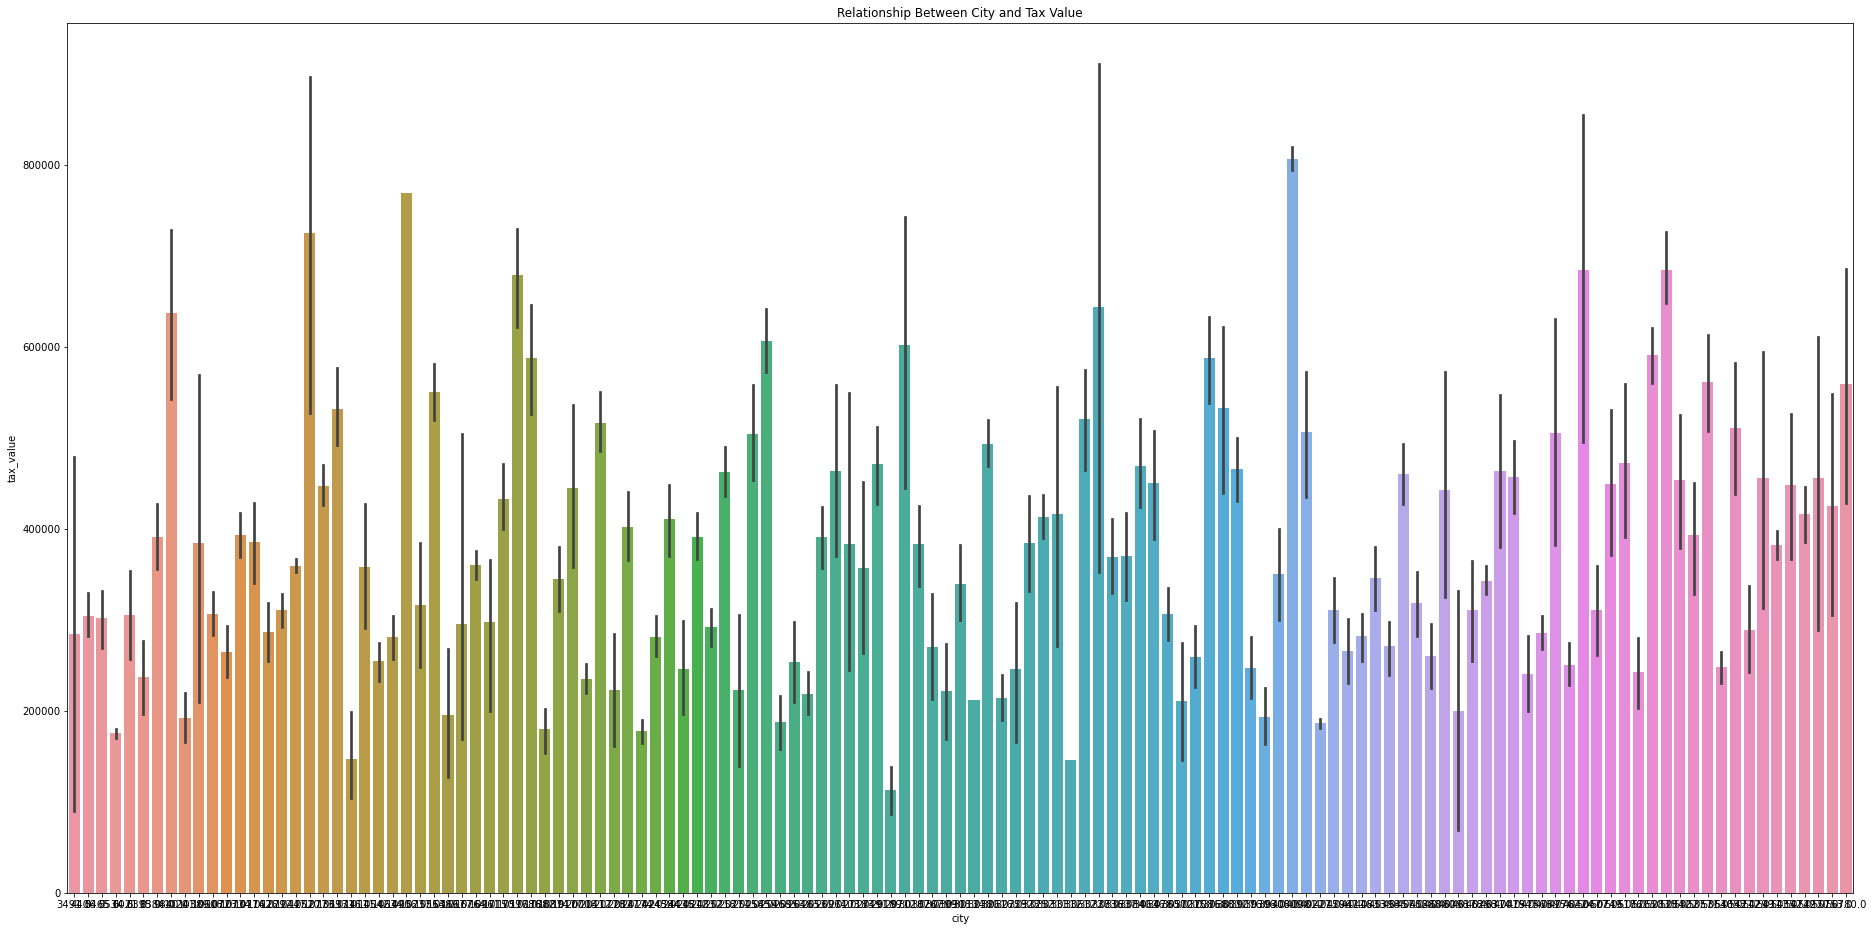

In [7]:
# Creating a barplot to visualize the relationship between city and tax_value 
plt.figure(figsize=(32,16))
sns.barplot(x='city', y='tax_value', data=train)
plt.title('Relationship Between City and Tax Value')
plt.show()

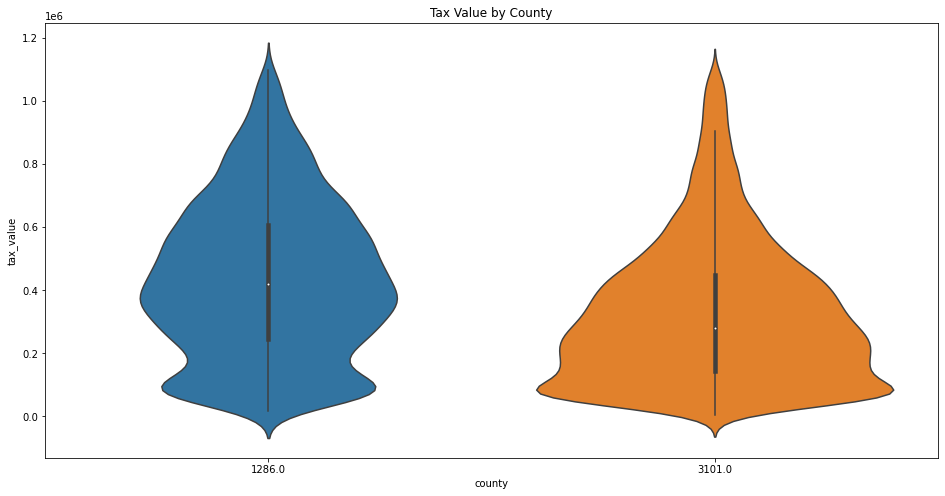

In [8]:
# Creating a violin plot to visualize the relationship between county and tax_value
plt.figure(figsize=(16,8))
sns.violinplot(x='county', y= 'tax_value', data=train)
plt.title('Tax Value by County')
plt.show()

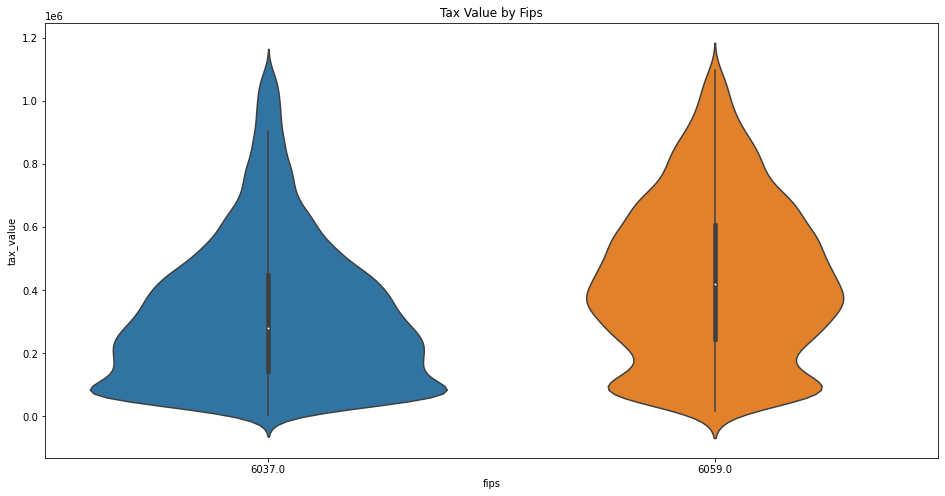

In [9]:
# creating a violin plot to visualize the relationship between fips vs tax_value
plt.figure(figsize=(16,8))
sns.violinplot(x='fips', y='tax_value', data=train)
plt.title('Tax Value by Fips')
plt.show()

## Explore Takeaways

> - After exploring the location based data in greater detail I could see a strong grouping/pattern within fips and county in relation to tax value due to lower variation between results
> - Looking at fips (code 6059 seems to have more houses with higher tax value) looking at county (code 1286 seems to have more houses with higher tax value)
> - At this point we now have strong contenders in the following features: area, fips, and county

# Modeling Phase

## Feature Selection

In [10]:
# Using Recursive Feature Elimination to solidify/reinforce which independent variables will be used in model creation
evaluate.rfe(X_train, y_train, 4)

,rfe_ranking
bedrooms,3
bathrooms,2
garages,8
pools,7
area,1
lot_size,5
fips,1
county,1
city,6
zip,1


I will be choosing the following features for model creation:

> - area
> - county
> - zip
> - fips


In [11]:
# Eliminate columns that weren't selected to be used in modeling
X_train_alt = X_train.drop(columns=['bedrooms', 'garages', 'pools', 'lot_size', 'city', 'decade'])
X_validate_alt = X_validate.drop(columns=['bedrooms', 'garages', 'pools', 'lot_size', 'city', 'decade'])

# Create a dataframe for target variable
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establish baseline predictions
tax_value_mean = y_train['tax_value'].mean()
y_train['tax_value_mean'] = tax_value_mean
y_validate['tax_value_mean'] = tax_value_mean

# Calculate RMSE for train and validate dataset
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** .5

print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

# Create a dataframe that tracks the metrics that we will use to compare each model
metric_df = pd.DataFrame(
    data=[{
        'model': 'mean_baseline',
        'rmse': rmse_validate,
        'r^2': explained_variance_score(y_validate.tax_value, y_validate.tax_value_mean)
    }])

RMSE using Mean
Train/In-Sample:  238786.62 
Validate/Out-of-Sample:  240294.43


### OLS Model

In [12]:
# creating an Ordinary Least Squares model
metric_df = evaluate.model_metrics(LinearRegression(), X_train_alt, y_train, X_validate_alt, y_validate, metric_df)

Name for model? OLS


### LASSO + LARS Model

In [13]:
# creating a Lasso + Lars model
metric_df = evaluate.model_metrics(LassoLars(alpha=1), X_train_alt, y_train, X_validate_alt, y_validate, metric_df)

Name for model? Lasso


### GLM

In [14]:
# creating a Generalized Linear Model
metric_df = evaluate.model_metrics(TweedieRegressor(power = 1, alpha = 1), X_train_alt, y_train, X_validate_alt, y_validate, metric_df)

Name for model? GLM


### Polynomial Regression Model

In [15]:
# making the method
pf = PolynomialFeatures(degree = 2)

# fitting the method and transforming the features into polynomial features
X_train_d2 = pf.fit_transform(X_train_alt)

X_validate_d2 = pf.transform(X_validate_alt)

# making the model
lm2 = LinearRegression(normalize=True)

# fitting the model to the transformed features
lm2.fit(X_train_d2, y_train.tax_value)

# making predictions
in_sample_pred = lm2.predict(X_train_d2)
out_sample_pred = lm2.predict(X_validate_d2)
model_name = input('Name for model?')
y_train[model_name] = in_sample_pred
y_validate[model_name] = out_sample_pred

# evaluating error
rmse_val = mean_squared_error(y_validate['tax_value'], out_sample_pred, squared=False)
r_squared_val = explained_variance_score(y_validate['tax_value'], out_sample_pred)

# appending metrics to metrics table
metric_df = metric_df.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    }, ignore_index=True)

Name for model? Poly


In [16]:
metric_df

,model,rmse,r^2
0,mean_baseline,240294.425118,0.000000
1,OLS,211431.738622,0.225858
2,Lasso,215216.928466,0.197840
3,GLM,212378.778510,0.218919
4,Poly,208417.787007,0.247714


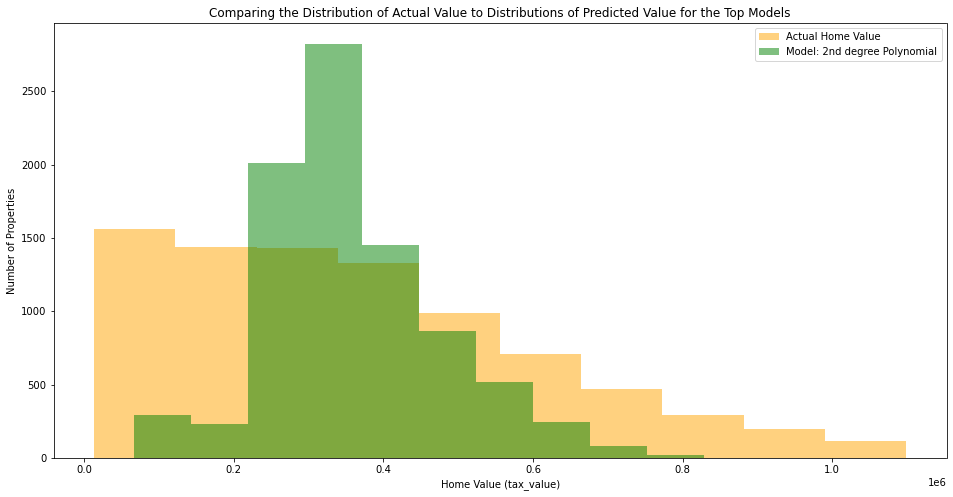

In [35]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='orange', alpha=.5, label="Actual Home Value")
plt.hist(out_sample_pred, color='green', alpha=.5, label="Model: 2nd degree Polynomial")
plt.xlabel("Home Value (tax_value)")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Value to Distributions of Predicted Value for the Top Models")
plt.legend()
plt.show()

In [ ]:
X_test_alt = X_test.drop(columns=['bedrooms', 'garages', 'pools', 'lot_size', 'city', 'decade'])
y_test = pd.DataFrame(y_test)
y_test['tax_value_mean'] = tax_value_mean
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_mean) ** .5

test_metric_df = pd.DataFrame(
    data=[{
        'model': 'mean_baseline',
        'rmse': rmse_test,
        'r^2': explained_variance_score(y_test.tax_value, y_test.tax_value_mean)
    }])

In [ ]:
X_test_d2 = pf.transform(X_test_alt)
test_pred = lm2.predict(X_test_d2)
model_name = input('Name for model?')
y_test[model_name] = test_pred

rmse_val = mean_squared_error(y_test['tax_value'], test_pred, squared=False)
r_squared_val = explained_variance_score(y_test['tax_value'], test_pred)

test_metric_df = test_metric_df.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    }, ignore_index=True)

test_metric_df

# Conclusions and Recommendations

> - Utilizing a combination of location based features and spatial features I was able to increase the accuracy of predictions in terms of Home Value by 25% from baseline.  

> - There's still much room for improvement in terms of reducing error so my recommendations are that we ensure that our data collecting efforts provide less missing values so that we can have a larger sample to work off of.

> - Next Steps for improving home value prediction performance is possibly using a different method of modeling to see if we can provide a more accurate prediction in the future with or without better data.